# Modelo 5: Regressão

# Importação de Variáveis e Indicadores

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

btc = pd.read_excel("../wrangled_data/serie_bitcoin.xlsx", index_col = "Data")
variaveis = pd.read_excel("../wrangled_data/variaveis.xlsx", index_col = "Data")

stop_fixo = pd.read_excel("../wrangled_data/stop_fixo.xlsx", index_col = "Data")
stop_vol = pd.read_excel("../wrangled_data/stop_vol.xlsx", index_col = "Data")

# Separação Treinamento - Teste

In [29]:
variaveis.dropna(inplace = True)
df = variaveis.join(stop_fixo)

# Período de Treinamento
ini_treino = "2011-02-01"
fim_treino = "2018-12-31"
X_train = variaveis[ini_treino:fim_treino]
y_train = df["Alvo_Contínuo"][ini_treino:fim_treino]

# Período de Teste
ini_teste = "2019-01-01"
fim_teste = "2021-07-31"
X_test = variaveis[ini_teste:fim_teste]
y_test = df["Alvo_Contínuo"][ini_teste:fim_teste]

# Modelagem

In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

### Otimização

Hiperparâmetros a serem otimizados:

* hidden_layer_sizes -> tupla contendo o número de neurônios dentro de cada camada (padrão: uma camada de 100 neurons)
* max_iter -> número máximo de iterações a serem realizadas pelo método de backpropagation
* alpha -> o valor máximo de alteração dos coeficientes em cada iteração, para minimizar a função de custo (padrão: 0.0001)
* solver -> Algoritmo utilizado para encontrar a solução ótima, cujo tempo de obtenção da resposta varia. Opções: 'lbfgs', 'sgd' e 'adam'.

#### Treinamento

In [34]:
modelo = MLPRegressor(random_state = 42, shuffle = True, activation = "tanh", solver = "sgd", learning_rate = "adaptive")

parametros = {'alpha': np.logspace(-1, 1, 20),
              'max_iter': [5, 15, 25, 50, 100]}

melhor_modelo = GridSearchCV(modelo, parametros, n_jobs = -1, cv = 10, scoring = "neg_root_mean_squared_error")
melhor_modelo.fit(X_train, y_train)

print('Melhor conjunto de parâmetros:\n', melhor_modelo.best_params_)

Melhor conjunto de parâmetros:
 {'alpha': 10.0, 'max_iter': 100}


C:\Users\Bruno Marcelino\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Teste

In [35]:
y_pred_train = melhor_modelo.predict(X_train)
y_pred_test = melhor_modelo.predict(X_test)

#### Avaliação

In [36]:
# Treinamento
print(r2_score(y_train, y_pred_train)) # R-Quadrado
print(mean_absolute_error(y_train, y_pred_train)) # Erro Absoluto Médio
print(mean_squared_error(y_train, y_pred_train, squared = False)) # Raiz do Erro Quadrático Médio (RMSE)
print(mean_absolute_error(y_train, y_pred_train)/y_test.mean()) # MAE / Média do conjunto

-0.0201357123294279
0.03362472865674677
0.05655866460531977
10.659383433454531


In [37]:
# Teste
print(r2_score(y_test, y_pred_test)) # R-Quadrado
print(mean_absolute_error(y_test, y_pred_test)) # Erro Absoluto Médio
print(mean_squared_error(y_test, y_pred_test, squared = False)) # Raiz do Erro Quadrático Médio (RMSE)
print(mean_absolute_error(y_test, y_pred_test)/y_test.mean()) # MAE / Média do conjunto

-0.14122485551712693
0.027453859430241617
0.042371146411797296
8.703154674718506


#### Backtest

In [38]:
y_pred_test

array([ 1.56045201e-03,  1.57202313e-03,  1.57439649e-03,  1.57723607e-03,
        1.57761504e-03,  1.57083646e-03,  1.58546118e-03,  1.58354614e-03,
        1.57613943e-03,  1.58076743e-03,  1.58458707e-03,  1.58173162e-03,
        1.61011652e-03,  1.61307462e-03,  1.61498461e-03,  1.62071316e-03,
        1.61041833e-03,  1.65424173e-03,  1.61947410e-03,  1.59850412e-03,
        1.61662604e-03,  1.61809142e-03,  1.66633047e-03,  1.62829523e-03,
        1.62771124e-03,  1.64444613e-03,  1.60943758e-03,  1.60597541e-03,
        1.60307120e-03,  1.61780174e-03,  1.62394687e-03,  1.61337954e-03,
        1.63926006e-03,  1.62830996e-03,  1.65892349e-03,  1.63537267e-03,
        1.62709505e-03,  1.63897336e-03,  1.64606134e-03,  1.63243782e-03,
        1.62829871e-03,  1.77327484e-03,  1.69060589e-03,  1.67818880e-03,
        1.71333988e-03,  1.74778638e-03,  1.73544092e-03,  1.69970798e-03,
        1.68845410e-03,  1.71531951e-03,  1.69773316e-03,  1.75247040e-03,
        1.69853281e-03,  

Retorno BH: [368.67672704] %
Retorno do Modelo: [-32.76807971] %


<AxesSubplot:xlabel='Data'>

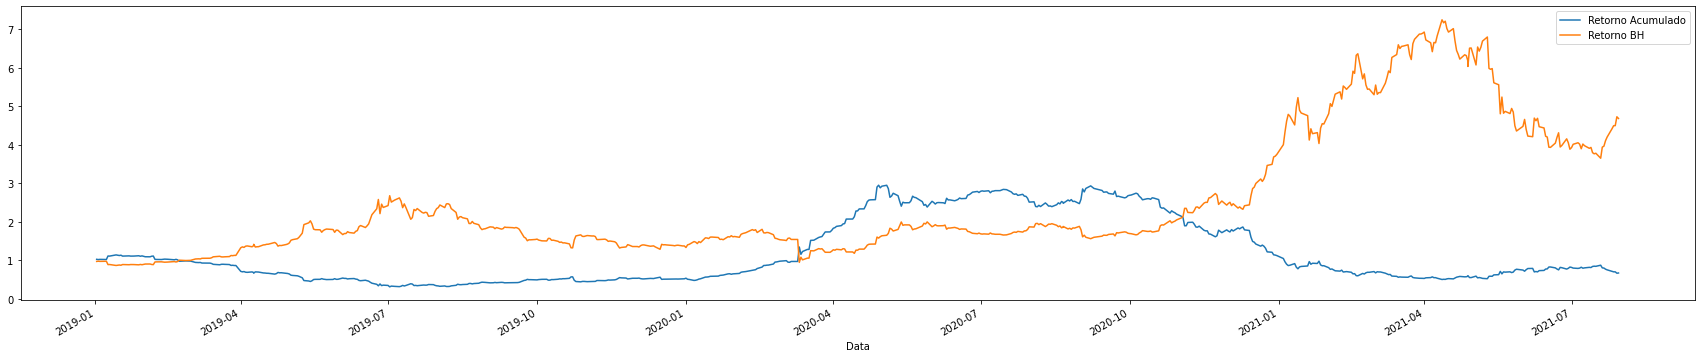

In [39]:
resultado = pd.DataFrame()
resultado["Observado"] = np.array(y_test)
resultado["Operação"] = np.where(pd.Series(y_pred_test) >= 0, 1, 0)
resultado["Operação"].value_counts()

bt = pd.DataFrame()
bt["Alvo"] = df["Alvo_Contínuo"][ini_teste:fim_teste].reset_index(drop = True)
bt["Sinal"] = resultado["Operação"]
bt.index = df["Alvo_Contínuo"][ini_teste:fim_teste].index

bt["Retorno Diário"] = np.where(bt["Sinal"] < bt["Alvo"], bt["Alvo"], -bt["Alvo"])

bt["Retorno Acumulado"] = (bt["Retorno Diário"] + 1).cumprod()
bt["Retorno BH"] = (bt["Alvo"] + 1).cumprod()

print("Retorno BH:", (bt.tail(1)["Retorno BH"].values-1)*100, "%")
print("Retorno do Modelo:", (bt.tail(1)["Retorno Acumulado"].values-1)*100, "%")

bt[["Retorno Acumulado", "Retorno BH"]].plot(figsize=(30,6))

In [40]:
# Acrescentando Stop
# stop = 0.3
# bt = bt.join(df[["Stop_Long", "Stop_Short"]])
# bt["Retorno Long"] = np.where(bt["Sinal"] == 1, bt["Alvo"], 0)
# bt["Retorno Short"] = np.where(bt["Sinal"] == -1, -bt["Alvo"], 0)
# # bt["Retorno Long"] = np.where(bt["Stop_Long"] == 1, -stop, bt["Retorno Long"])
# # bt["Retorno Short"] = np.where(bt["Stop_Short"] == 1, -stop, bt["Retorno Short"])
# bt["Retorno Diário"] = bt["Retorno Long"] + bt["Retorno Short"]